# Project: Advanced Lane Finding - Camera Calibration
This is a subsection from the Advanced Lane Finding project and concerns only the Camera Calibration requirements.

The main project pipeline is documented at 02-proj-advancedLaneFinding.ipynb in this same directory.

### Rubric: Camera Calibration 
 - **Criteria**: Briefly state how you computed the camera matrix and distortion coefficients. Provide an example of a distortion corrected calibration image.
 - **Acceptance criteria**: OpenCV functions or other methods were used to calculate the correct camera matrix and distortion coefficients using the calibration chessboard images provided in the repository (note these are 9x6 chessboard images, unlike the 8x6 images used in the lesson). The distortion matrix should be used to un-distort one of the calibration images provided as a demonstration that the calibration is correct. Example of undistorted calibration image is Included in the writeup (or saved to a folder).
 - **Output**: **PASS** 

> **HMA**: Please find below the notes on the used functions to calibrate the camera. The section "Example - Undistort and Warp" presents a pipeline using the calibration camera parameters and output from each step, from an Original image to Warped image. 

In [1]:
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def pltSingle(img, title, axis_grid='off'):
    f, ax = plt.subplots(1,1)
    ax.imshow(img)
    ax.set_title(title)
    ax.axis(axis_grid)
    plt.show()

In [3]:
def pltCompare(img1, title1, img2, title2, axis_grid='off'):
    f, (ax1, ax2) = plt.subplots(1,2)
    ax1.imshow(img1)
    ax1.set_title(title1)
    ax1.axis(axis_grid)
    ax2.imshow(img2)
    ax2.set_title(title2)
    ax2.axis(axis_grid)
    plt.show()

## Visualization and Parameters definition

The initial step for calibration is to identify the type of chessboar used for the calibration process. 

The 'calibration2.jpg' was used for visualization, since the first image from the calibration set 'calibration1.jpg' did not properly presented all internal corners from the board for count. It was nevertheless used at the calibration pipeline, however the **findChessboardCorners()** has not found all needed corners, so this image was not used for the calibration.

In [4]:
# Parameters
# Path for Calibration directory 
calibration_DIR = '10-input-cameraCalibration/'
# Filename for Calibration sample image
calibration_sample_FILE = 'calibration2.jpg'

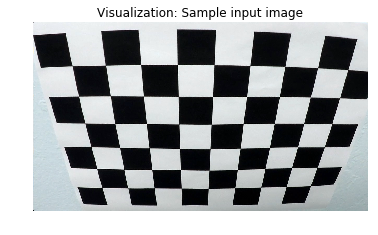

In [9]:
# Print Calibration sample image
fname = calibration_DIR + calibration_sample_FILE
img_sample = cv2.imread(fname)
pltSingle(img_sample, 'Visualization: Sample input image')

In [6]:
# Parameters:
# Number of inside corners in x
nx = 9
# Number of inside corners in y
ny = 6

## Camera calibration pipeline

The bottom-up pipeline for camera calibration is:
- The undistorted image is generated by **cv2.undistort()**
- The cv2.undistort() function needs parameters previously generated by **cv2.cameraCalibrate()** and 
- The cv2.cameraCalibrate function matches a np.array grid (object points) to points in an image. Tipically 20 sample pairs of image points and object points are required for a good calibration. In this pipeline, 4 corners  were automatically identified by **cv2.drawChessboardCorners()**, and the 4 matching points (image points) defined manually.
- The cv2.drawChessboardCorners() function returns the corners, or image points, which were initially detected by **cv2.findChessboardCorners()**.
- Finally cv2.findChessboardCorners() only need the sample images (one at a time) from the same chessboard from different angles in grayscale.

The code below presents this pipeline.

In [7]:
import numpy as np
import glob
import pickle

# Prepare object points
objp = np.zeros((ny*nx,3), np.float32)
objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob(calibration_DIR + 'calibration*.jpg')

# Step through the list and search for chessboard corners
for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)
            
# Process camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img.shape[1::-1], None, None) 

# Store camera calibration output
calibration_pickle = {}
calibration_pickle['mtx'] = mtx
calibration_pickle['dist'] = dist
pickle.dump(calibration_pickle, open('./20-output-cameraCalibration.p', 'wb' ) )

## Example - Undistort and Warp
The following section presents the code and output from Corners detection, Undistortion and image Warp.

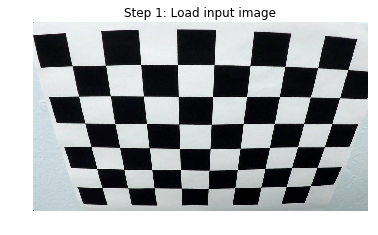

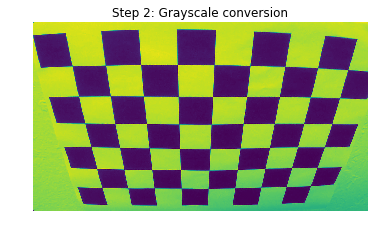

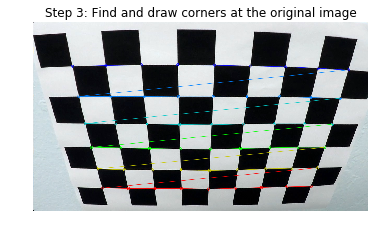

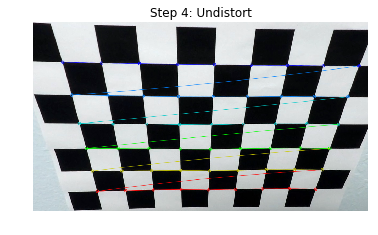

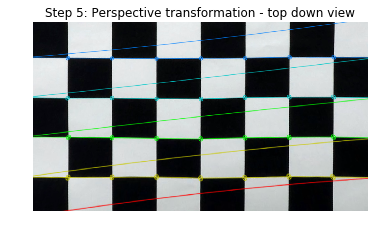

In [8]:
# Step 1: Load calibration sample image
fname = calibration_DIR + calibration_sample_FILE
img = cv2.imread(fname)
pltSingle(img, 'Step 1: Load input image')

# Step 2: Convert to grayscale - input to search for image corners
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
pltSingle(gray, 'Step 2: Grayscale conversion')

# Step 3: Find and Draw chessboard corners
ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
if ret == True:
    cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
    pltSingle(img, 'Step 3: Find and draw corners at the original image')
    
    # Step 4: Undistort using mtx and dist
    img = cv2.undistort(img, mtx, dist, None, mtx)
    pltSingle(img, 'Step 4: Undistort')

    # Define source points
    src = np.float32([corners[0], corners[nx-1], corners[-1], corners[-nx]])

    # Define destination points
    h = img.shape[0]
    w = img.shape[1]
    dst = np.float32([[0,0], [w, 0], [w,h], [0,h]])

    M = cv2.getPerspectiveTransform(src, dst)
    # Warp image to a top-down view
    warped = cv2.warpPerspective(img, M, img.shape[1::-1], flags=cv2.INTER_LINEAR)
    # Step 5: Perspective transformation at a top-down view from the original image
    pltSingle(warped, 'Step 5: Perspective transformation - top down view')
